In [172]:
from google.colab import drive

In [173]:
drive.mount('/content/drive')  # connect to google drive
base_dir = "drive/MyDrive/BA"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [174]:
%%capture
!pip install tensorflow_text

In [175]:
import numpy
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

# fix random seed for reproducibility
numpy.random.seed(42)

### Data preprocessing

#### Load Data

In [176]:
dataset = "CE-ACL_full.csv"
data = pd.read_csv(os.path.join(base_dir, dataset))

In [177]:
claims = data[data["Claim"] == True]
no_claims = data[data["Claim"] == False].sample(n=len(claims), random_state=42) # sample 1:1
data_sample = pd.concat([claims, no_claims])

In [178]:
texts = data_sample["Sentence"]
labels = data_sample["Claim"]

In [179]:
labels = labels.apply(lambda x: 0 if x==False else 1)

#### Create embeddings

In [180]:
max_words = 5000  # consider the top n words in the data set only
maxlen = len(data_sample["Sentence"].max())  # longest sentence to calculate max embedding len

def create_embeddings(data, labels):
  tokenizer = Tokenizer(num_words=max_words)  # create tokanizer
  tokenizer.fit_on_texts(texts)  # tokenize sentences
  sequences = tokenizer.texts_to_sequences(texts) # get sequences for sentences

  data = pad_sequences(sequences, maxlen=maxlen) # padding for shorter sentences
  labels = np.asarray(labels) # return labels
  
  # reporting
  word_index = tokenizer.word_index
  print('Found %s unique tokens' % len(word_index))
  print('Shape of data tensor:', data.shape)
  print('Shape of label tensor:', labels.shape)

  return data, labels

### Split data

In [181]:
data, labels = create_embeddings(data, labels)

Found 9291 unique tokens
Shape of data tensor: (2468, 197)
Shape of label tensor: (2468,)


In [182]:
x_train, x_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=0
)

In [183]:
print(x_train.shape)
print(y_train.shape)

(1974, 197)
(1974,)


In [184]:
print(x_test.shape)
print(y_test.shape)

(494, 197)
(494,)


### create Model

In [185]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

# create the model
embedding_vecor_length = 32
model = Sequential()

model.add(Embedding(max_words, embedding_vecor_length, input_length=maxlen))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 197, 32)           160000    
                                                                 
 lstm_13 (LSTM)              (None, 100)               53200     
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


### Fit model

In [186]:
history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.3)

Epoch 1/20
11/11 [==============================] - 10s 679ms/step - loss: 0.6900 - accuracy: 0.5062 - val_loss: 0.6722 - val_accuracy: 0.5818
Epoch 2/20
11/11 [==============================] - 7s 645ms/step - loss: 0.6664 - accuracy: 0.5909 - val_loss: 0.6561 - val_accuracy: 0.6172
Epoch 3/20
11/11 [==============================] - 7s 645ms/step - loss: 0.6342 - accuracy: 0.6191 - val_loss: 0.6371 - val_accuracy: 0.6324
Epoch 4/20
11/11 [==============================] - 7s 647ms/step - loss: 0.5624 - accuracy: 0.7422 - val_loss: 0.5807 - val_accuracy: 0.7032
Epoch 5/20
11/11 [==============================] - 7s 652ms/step - loss: 0.4451 - accuracy: 0.8190 - val_loss: 0.5262 - val_accuracy: 0.7538
Epoch 6/20
11/11 [==============================] - 7s 638ms/step - loss: 0.3153 - accuracy: 0.8769 - val_loss: 0.5384 - val_accuracy: 0.7521
Epoch 7/20
11/11 [==============================] - 7s 647ms/step - loss: 0.2096 - accuracy: 0.9160 - val_loss: 0.5556 - val_accuracy: 0.7740
Epoch

### Evaluate Model

In [187]:
scores = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

16/16 [==============================] - 1s 46ms/step - loss: 1.0738 - accuracy: 0.7267
Accuracy: 72.67%


In [198]:
# preds = model.predict(x_test)
predictions = model.predict(np.array(x_test))

In [195]:
res = []
for i in predictions:
  if i < 0.5:
    res.append(0)
  else:
    res.append(1)

In [197]:
print(classification_report(res, y_test))


              precision    recall  f1-score   support

           0       0.62      0.76      0.68       190
           1       0.83      0.70      0.76       304

    accuracy                           0.73       494
   macro avg       0.72      0.73      0.72       494
weighted avg       0.75      0.73      0.73       494



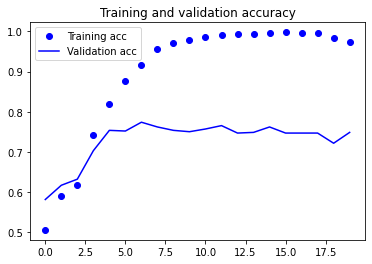

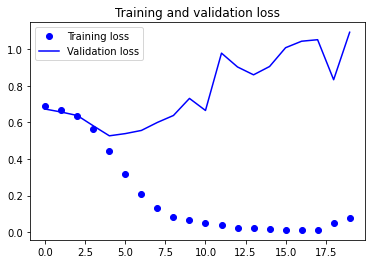

In [199]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()